# Krige development

Author: Ilan Valencius

Institution: Boston College

Purpose: Develop proper kriging procedures for surface wind speeds.

Created: 11-3-2023

In [2]:
import os
from tqdm import tqdm, trange
# import sys
from glob import glob
# Better debugging printing
from icecream import ic
# Working with data
import xarray as xr
import numpy as np
import pandas as pd
import regionmask
import scipy.stats as stats
# Plotting imports
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
# Parallel processing
from joblib import Parallel, delayed, parallel_config
# Working with geographic datatypes
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
# Kriging the data
# from pykrige.ok import OrdinaryKriging
import gstools as gs
# Plotting Options
import scienceplots
plt.style.use(["science", "nature"]) # Can also add the style: "grid"
# plt.rcParams.update({
#     "font.family": "sans serif",   # specify font family here
#     "font.serif": ["Helvetica"],  # specify font here
#     "font.size":11})          # specify font size here

# Helper plotting functions
def update_projection(ax, axi, projection='3d', fig=None):
    if fig is None:
        fig = plt.gcf()
    rows, cols, start, stop = axi.get_subplotspec().get_geometry()
    ax.flat[start].remove()
    ax.flat[start] = fig.add_subplot(rows, cols, start+1, projection=projection)

# Load Datasources

Elevation data sourced from [TEMIS](https://www.temis.nl/data/gmted2010/)

# READ THIS https://gistbok.ucgis.org/bok-topics/kriging-interpolation#Impacts

In [3]:
# HadISD
tex = (
    xr.load_dataset("../data/HadISD/us-states/Texas.nc")
    .where(lambda x: x['windspeeds'] >= 0)
    .sel(time=slice("2005-01-01", "2005-02-01"))
    # .mean('time')
    .where(lambda x: x['windspeeds'].notnull(), drop=True)
)

# Load regionmask for US States
states = regionmask.defined_regions.natural_earth_v5_0_0.us_states_50
tex_key = states.map_keys('TX')

# TEMIS elevation data, 0.0625 degree resolution
temis = (
    xr.load_dataset("../data/TEMIS/GMTED2010_15n015_00625deg.nc")
    .isel(nbounds=1)
)
# GFDL AM4 data
# am4 = (
#     xr.open_mfdataset(
#         '../data/nudged_2005/monthly/*.nc', combine="by_coords"
#     )
#     .assign(net = lambda x: np.sqrt(x["ucomp"]**2 + x["vcomp"]**2))
#     .sel(time="2005-01-16")
#     .squeeze()
#     .load()
# )


# Mask data sources by state
temis_tex = temis.where(states.mask(temis['longitude'], temis['latitude']) == tex_key, drop=True)
# am4_tex = am4.where(states.mask(am4) == tex_key, drop=True)
# Mask out places with no data
mask = temis_tex['elevation'].isnull()
# Get external variables at station location 
temis_at_station = temis.sel(
    latitude=tex['latitude'], longitude=tex['longitude'], method='nearest'
)
# am4_at_station = am4.sel(
#     lat=tex['latitude'], lon=tex['longitude'], method='nearest'
# )
# merra2_at_station = merra2.sel(
#     lat=tex['latitude'], lon=tex['longitude'], method='nearest'
# ).load()

## Plot Station Locations

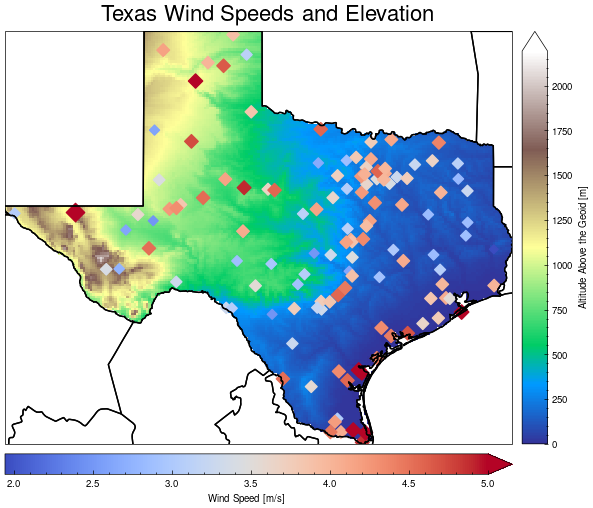

In [4]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.axes as maxes

fig, ax = plt.subplots(figsize=(7,7),subplot_kw=dict(projection=ccrs.PlateCarree()))
e = temis_tex['elevation'].plot(
    ax = ax, transform=ccrs.PlateCarree(), 
    cmap='terrain', add_colorbar=False, add_labels=False
)
c = ax.scatter(
    tex['longitude'], tex['latitude'], tex.mean('time')['windspeeds']*10, 
    c=tex.mean('time')['windspeeds'], transform=ccrs.PlateCarree(),
    cmap='coolwarm', vmax=5, marker='D'
)
ax.add_feature(cfeature.STATES)
ax.coastlines()
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", axes_class=maxes.Axes, pad=0.1)
fig.colorbar(c, cax=cax, extend='max', label='Wind Speed [m/s]', orientation='horizontal')
cax2 = divider.append_axes("right", size="5%", axes_class=maxes.Axes, pad=0.1)
fig.colorbar(e, cax=cax2, extend='max', label='Altitude Above the Geoid [m]', orientation='vertical')

fig.suptitle("Texas Wind Speeds and Elevation", y=0.85, fontsize=16)
plt.show()

## Get Measurement error at each site

100%|██████████| 124/124 [00:00<00:00, 6061.77it/s]


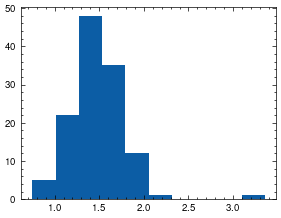

In [5]:
# Num stations
num_stations = tex['station_id'].size
# Reduce data over time (1 month)
tex_monthly = tex.mean('time')
# Add field for gamma error
# tex_monthly['gamma_err'] = xr.zeros_like(tex_monthly['station_id'])
errs = []
for s in trange(num_stations):
    # Station data
    station = tex.isel(station_id=s)
    # Filter out bad windspeeds
    wind = station['windspeeds'].values
    good_wind = wind[wind > 0]
    if len(good_wind) == 1:
        # If 1 observation, cannot determine error
        errs.append(np.nan)
    else:
        ag,bg,cg = stats.gamma.fit(good_wind, floc=0)
        errs.append(stats.gamma.std(ag,bg,cg))
        
# For sites with one observation, set error to be mean of all other errors
errs = np.array(errs)
errs[np.isnan(errs)] = np.nanmean(errs)
# Add gamma errors to dataset
tex_monthly['gamma_err'] = xr.DataArray(errs, dims='station_id', coords={'station_id': tex_monthly['station_id']})
tex_monthly['gamma_err'].attrs['units'] = 'm/s'
plt.hist(tex_monthly['gamma_err'])
plt.show()

## Get difference between HadISD and TEMIS Elevations

Enough extreme differences so use TEMIS elevation data.

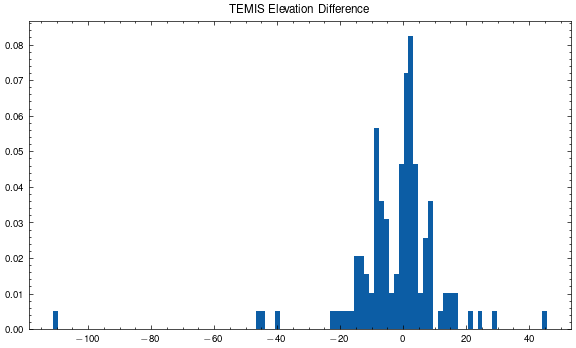

In [6]:
# Get TEMIS elevation at each station
# closest = temis_tex.sel(
#     latitude=tex['latitude'], longitude=tex['longitude'], method='nearest'
# )
# ffill = temis_tex.sel(
#     latitude=tex['latitude'], longitude=tex['longitude'], method='ffill'
# )
# # For stations where nearest is nan, use ffill
# temis_at_station = closest.where(closest.notnull(), ffill)
# Std at station
# Difference
diff = temis_at_station['elevation'] - tex_monthly['elevation']

# Plot the data
fig, ax = plt.subplots(figsize=(7,4))
ax.hist(diff, bins=100, density=True, label='Difference')
plt.title("TEMIS Elevation Difference")
plt.show()

# Kriging

## Estimate variogram

From https://geostat-framework.readthedocs.io/projects/gstools/en/stable/examples/03_variogram/01_find_best_model.html#sphx-glr-examples-03-variogram-01-find-best-model-py

  0%|          | 0/9 [00:00<?, ?it/s]/Users/ilanvalencius/anaconda3/envs/xcdat/lib/python3.11/site-packages/gstools/covmodel/plot.py:121: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
 56%|█████▌    | 5/9 [00:00<00:00, 43.56it/s]/Users/ilanvalencius/anaconda3/envs/xcdat/lib/python3.11/site-packages/gstools/covmodel/tools.py:553: AttributeWarning: Dimension 3 is not appropriate for this model.
  warnings.warn(
100%|██████████| 9/9 [00:00<00:00, 36.34it/s]


RANKING by Pseudo-r2 score
     1.          Stable: 0.6631: Stable(latlon=True, var=0.921, len_scale=1.14, nugget=0.639, geo_scale=57.3, alpha=0.666)
     2.          Matern: 0.66239: Matern(latlon=True, var=0.944, len_scale=1.01, nugget=0.585, geo_scale=57.3, nu=0.228)
     3.     Exponential: 0.65859: Exponential(latlon=True, var=0.716, len_scale=1.17, nugget=0.77, geo_scale=57.3)
     4.        Rational: 0.65851: Rational(latlon=True, var=0.746, len_scale=0.77, nugget=0.812, geo_scale=57.3, alpha=0.5)
     5.  SuperSpherical: 0.64496: SuperSpherical(latlon=True, var=0.628, len_scale=14.0, nugget=0.833, geo_scale=57.3, nu=50.0)
     6.       Spherical: 0.63039: Spherical(latlon=True, var=0.589, len_scale=2.92, nugget=0.862, geo_scale=57.3)
     7.        Circular: 0.62423: Circular(latlon=True, var=0.575, len_scale=2.62, nugget=0.875, geo_scale=57.3)
     8.        Gaussian: 0.61782: Gaussian(latlon=True, var=0.531, len_scale=1.11, nugget=0.908, geo_scale=57.3)
     9.         JBesse

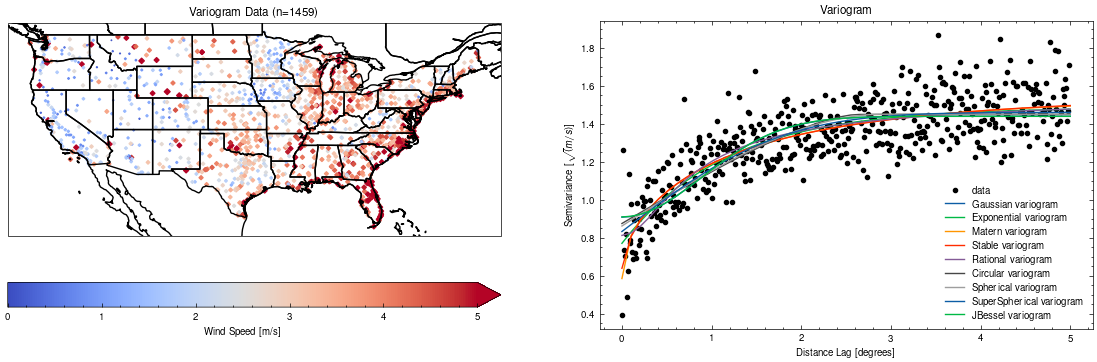

In [99]:
# # Get all station files
# state_files = [
#     f for f in glob('../data/HadISD/us-states/*.nc') if
#     f.find('Alaska') == -1 and f.find('Hawaii') == -1
# ]

# # Load all station data from this region
# all_states = []
# for f in state_files:
#     s = (
#         xr.open_dataset(f)
#         .expand_dims(dim={"state": [f.split('/')[-1][:-3]]}, axis=1)
#         .sel(time=slice("2005-01-15", "2005-01-17")) # All of 2005
#         .where(lambda x: x['windspeeds'] >= 0, drop=True)
#         .mean('time')
#     )
#     all_states.append(s)

# states = xr.concat(all_states, dim="state")

variogram_val = states['windspeeds'].values.flatten()
good_vals = np.isfinite(variogram_val)
variogram_val = variogram_val[good_vals]
# cond_err = NOTHING RIGHT NOW
variogram_pos = (
    states['longitude'].values.flatten()[good_vals],
    states['latitude'].values.flatten()[good_vals],
)

fig, ax = plt.subplots(ncols=2, figsize=(7*2,4), subplot_kw=dict(projection=ccrs.PlateCarree()))
c = ax[0].scatter(variogram_pos[0], variogram_pos[1], variogram_val, c=variogram_val, cmap='coolwarm', vmax=5, marker='D')
ax[0].add_feature(cfeature.STATES)
ax[0].coastlines()
plt.colorbar(c, label='Wind Speed [m/s]', orientation='horizontal', extend='max')
ax[0].set_title(f'Variogram Data (n={len(variogram_val)})')

models = {
    "Gaussian": gs.Gaussian,
    "Exponential": gs.Exponential,
    "Matern": gs.Matern,
    "Stable": gs.Stable,
    "Rational": gs.Rational,
    "Circular": gs.Circular,
    "Spherical": gs.Spherical,
    "SuperSpherical": gs.SuperSpherical,
    "JBessel": gs.JBessel,
}
scores = {}
ms = {}
bins = np.arange(0, 5, 0.01) # 0.1 degree bins
# bins = gs.variogram.standard_bins(variogram_pos, bin_no=499, max_dist = 5, latlon=True, geo_scale=gs.tools.DEGREE_SCALE)
bin_center, gamma = gs.vario_estimate(
    variogram_pos, variogram_val, bins,
    latlon=True, geo_scale=gs.tools.DEGREE_SCALE
)

# plot the estimated variogram
# fig, ax = plt.subplots(figsize=(7,4))
update_projection(ax, ax[1], projection='rectilinear')
ax[1].scatter(bin_center, gamma, color="k", label="data")
plt.title("Variogram")
ax[1].set_xlabel("Distance Lag [degrees]")
ax[1].set_ylabel(f'Semivariance [$\sqrt(m/s)$]')
# fit all models to the estimated variogram
for model in tqdm(models):
    fit_model = models[model](latlon=True, geo_scale=gs.tools.DEGREE_SCALE)
    try:
        para, pcov, r2 = fit_model.fit_variogram(bin_center, gamma, return_r2=True)
        fit_model.plot(x_max=5, ax=ax[1])
        scores[model] = r2
        ms[model] = fit_model
    except:
        scores[model] = np.nan
        ms[model] = ''
    
ranking = sorted(scores.items(), key=lambda item: item[1], reverse=True)
print("RANKING by Pseudo-r2 score")
for i, (model, score) in enumerate(ranking, 1):
    print(f"{i:>6}. {model:>15}: {score:.5}: {ms[model]}")

plt.show()

In [15]:
cond_val = tex_monthly['windspeeds'].values.flatten()
# cond_err = NOTHING RIGHT NOW
cond_pos = (
    tex_monthly['longitude'].values.flatten(),
    tex_monthly['latitude'].values.flatten(),
)
cond_errs = tex_monthly['gamma_err'].values.flatten()
lons, lats = np.meshgrid(temis_tex['longitude'].values.flatten(), temis_tex['latitude'].values.flatten())
temis_krige = temis_tex.fillna(-999)


## Helper function for plots

In [140]:
def krige_comparison_plots(cond_pos, cond_val, cond_errs, k_field, e_field, station_pred, station_err):
    fig, ax = plt.subplots(ncols=3, figsize=(12,4), subplot_kw=dict(projection=ccrs.PlateCarree()))
    # Wind speeds
    c1 = ax[0].pcolor(
        lons, lats, k_field, cmap='magma', transform=ccrs.PlateCarree(),
        vmax=np.nanquantile(k_field, 0.95)
    )
    ax[0].scatter(cond_pos[0], cond_pos[1], color='k', marker='x')
    ax[0].add_feature(cfeature.STATES)
    ax[0].coastlines()

    # Errors
    c2 = ax[1].pcolor(
        lons, lats, e_field, cmap='cividis', transform=ccrs.PlateCarree(),
        vmax=np.nanquantile(e_field, 0.95)
    )
    ax[1].scatter(cond_pos[0], cond_pos[1], color='k', marker='x')
    ax[1].add_feature(cfeature.STATES)
    ax[1].coastlines()

    # Plot error between observed and kriged speeds
    # Difference data
    # diff = cond_val - station_pred
    # Check whether observed 
    # Plot
    # c3 = ax[2].scatter(cond_pos[0], cond_pos[1], c=diff, cmap='coolwarm')
    update_projection(ax, ax[2], projection='rectilinear')
    ax[2].errorbar(cond_val, station_pred, xerr=cond_errs, yerr=station_err, fmt='o', color='k', alpha=0.9, ecolor='gray', capsize=5)
    ax[2].set_title("Difference between Observed and Kriged Wind Speeds")
    ax[2].set_xlabel("Observed Wind Speed [m/s]")
    ax[2].set_ylabel("Kriged Wind Speed [m/s]")
    ax[2].set_xlim(1, 7)
    ax[2].set_ylim(1, 7)
    # Plot 1:1 line
    ax[2].plot([0, 10], [0, 10], color='r', linestyle='--', linewidth=1)
    ax[2].set_aspect('equal', 'box')


    # Add colorbars at bottom
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes("bottom", size="5%", axes_class=maxes.Axes, pad=0.2)
    fig.colorbar(c1, cax=cax, extend='max', label='Wind Speed [m/s]', orientation='horizontal')
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes("bottom", size="5%", axes_class=maxes.Axes, pad=0.2)
    fig.colorbar(c2, cax=cax, extend='max', label='Error [m/s]', orientation='horizontal')
    # divider = make_axes_locatable(ax[2])
    # cax = divider.append_axes("bottom", size="5%", axes_class=maxes.Axes, pad=0.2)
    # fig.colorbar(c3, cax=cax,label='Predicted Error [m/s]', orientation='horizontal')

    plt.show()
    

## External Drift Kriging (EDK)

Using elevation as the external drift term.

https://www.linkedin.com/pulse/kriging-external-drift-most-powerful-guide-marcel-cedrez/

https://stackoverflow.com/questions/56419732/what-is-internal-drift-and-external-drift

For external drift kriging, you have to provide the drift value at each target point, where you want to interpolate your data. When you have a functional drift, you only have to provide that function and the drift value is determined by the position of the target point.

Theoretical approach for external drift kriging
- Use elevation as proxy
- Use surface winds from AM4 as proxy (scale AM4 to observed winds) (need all of 2005 data)
    - Can then use AM4 log ratio to scale wind heights vertically --> quantify the error

### Land Cover

From https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-land-cover?tab=overview

### Ensure correlation between various parameters

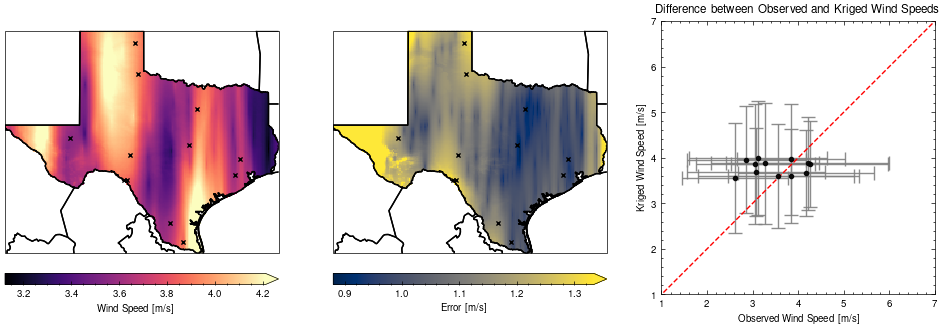

In [145]:
model = gs.Stable(latlon=True, var=0.921, len_scale=1.14, nugget=0.639, geo_scale=57.3, alpha=0.666)
drift = temis_at_station['elevation'].values.flatten()
    # temis.sel(
    #     latitude=states['latitude'].mean('state'), longitude=states['longitude'].mean('state'), 
    #     method='nearest'
    # )['elevation'].values.flatten()

# Get holdout stations
hs_ind =  np.random.choice(cond_val.shape[0], int(np.floor(len(cond_val)*0.1)), replace=False)
# Take indexes *not* in holdout stations
t_ind = np.setdiff1d(np.arange(cond_val.shape[0]), hs_ind)
krig = gs.krige.ExtDrift(
    model=model,
    cond_pos=(cond_pos[0][t_ind], cond_pos[1][t_ind]),
    cond_val=cond_val[t_ind],
    ext_drift = drift[t_ind],
    exact=False,
    cond_err=cond_errs[t_ind]
)
k, err = krig((lons.flatten(), lats.flatten()), ext_drift=[temis_krige['elevation'].values])

k_field = k.reshape(temis_tex['elevation'].shape)
e_field = err.reshape(temis_tex['elevation'].shape)

k_field[mask] = np.nan
e_field[mask] = np.nan
# Plot error between observed and kriged speeds
# Sample kriged data at station locations
holdout_pos = (cond_pos[0][hs_ind], cond_pos[1][hs_ind])
station_pred, station_err = krig(holdout_pos, ext_drift=drift[hs_ind])

krige_comparison_plots(holdout_pos, cond_val[hs_ind], cond_errs[hs_ind], k_field, e_field, station_pred, station_err)

## Regression Kriging

In [ ]:
# Define trend function
from sklearn.linear_model import LinearRegression
def simple_trend(lon, lat):
    return lon

model = LinearRegression().fit(temis_at_station['elevation'].values.reshape(-1, 1), cond_val.reshape(-1,1))
fig, ax = plt.subplots(figsize=(7,4))
ax.scatter(temis_at_station['elevation'], cond_val)
xs = np.linspace(0, 1600, 100).reshape(-1,1)
ax.plot(xs, model.predict(xs))
plt.show()

In [ ]:
model = gs.Cubic(var=0.502, len_scale=2.61, nugget=0.506, latlon=True, geo_scale=gs.tools.DEGREE_SCALE) # simple linear model
krig = gs.krige.ExtDrift(
    model=model,
    cond_pos=cond_pos,
    cond_val=cond_val,
    ext_drift = drift, 
    exact=False,
    cond_err=cond_errs,
    trend = simple_trend
)
k, err = krig((lons, lats), ext_drift = [temis_krige['elevation'].values.flatten(), temis_krige['elevation_stddev'].values.flatten()])

k_field = k.reshape(temis_tex['elevation'].shape)
e_field = err.reshape(temis_tex['elevation'].shape)

k_field[mask] = np.nan
e_field[mask] = np.nan
# Plot error between observed and kriged speeds
# Sample kriged data at station locations
station_pred, station_err = krig((cond_pos[0], cond_pos[1]), ext_drift=drift)

krige_comparison_plots(cond_pos, cond_val, cond_errs, k_field, e_field, station_pred, station_err)

# Krige all states

In [ ]:
# Get all station files
state_files = glob('../data/HadISD/us-states/*.nc')
# Load all station data from this region
all_states = []
for f in state_files:
    s = xr.open_dataset(f)
    # Add dimension to include state name
    s_label = s.expand_dims(dim={"state": [f.split('/')[-1][:-3]]}, axis=1)
    # Filter out bad dates
    s_label = s_label.sel(time=slice("2019-01-01", "2019-02-01"))
    # Filter out bad wind
    s_label = s_label.where(lambda x: x['windspeeds'] >= 0, drop=True)
    all_states.append(s_label.mean('time'))

states = xr.concat(all_states, dim="state")

In [ ]:
# TEMIS elevation data, 0.0625 degree resolution
temis = (
    xr.load_dataset("../data/TEMIS/GMTED2010_15n015_00625deg.nc")
    .isel(nbounds=1)
)
# GFDL AM4 data
am4 = (
    xr.open_mfdataset(
        '../data/nudged_2005/monthly/*.nc', combine="by_coords"
    )
    .assign(net = lambda x: np.sqrt(x["ucomp"]**2 + x["vcomp"]**2))
    .sel(time="2005-01-16")
    .squeeze()
    .load()
)

state_mask = regionmask.defined_regions.natural_earth_v5_0_0.us_states_50
t_all = temis.where(state_mask.mask(temis['longitude'], temis['latitude']).notnull(), drop=True)
am4_all = am4.where(state_mask.mask(am4).notnull(), drop=True)
t_station = temis.sel(
    latitude=states['latitude'].mean('state'), longitude=states['longitude'].mean('state'), method='nearest'
)
am4_station = am4.sel(
    lat=states['latitude'].mean('state'), lon=states['longitude'].mean('state'), method='nearest'
)

## Ensure correlation between variables and windspeed

In [ ]:
am4_station

In [ ]:
plt.scatter(am4_station['ps'], states.mean('state')['windspeeds'])

In [ ]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(4*5,4*5))

for i, l in enumerate(am4_station.level):
    ax = axs.flatten()[i]
    ax.scatter(am4_station['net'].sel(level=l), states.mean('state')['windspeeds'])
    ax.set_title(f"Level {l.values} Pressure")
    ax.set_xlabel("AM4 Wind Speed [m/s]")
    ax.set_ylabel("HadISD Wind Speed [m/s]")
plt.show()

In [ ]:
v_pos = (
    states['longitude'].mean('state').values.flatten(),
    states['latitude'].mean('state').values.flatten(),
)
v_val = states['windspeeds'].mean('state').values.flatten()

fit_model = gs.Cubic(latlon=True, geo_scale=gs.tools.DEGREE_SCALE)
bin_center, gamma = gs.vario_estimate(v_pos, v_val,latlon=True, geo_scale=gs.tools.DEGREE_SCALE)
fit_model.fit_variogram(bin_center, gamma) # nugget=False ???

fig, ax = plt.subplots(figsize=(7,4))
fit_model.plot(ax=ax, x_max=45)
ax.scatter(bin_center, gamma)
print(fit_model)
drift = [t_station['elevation_stddev'].values.flatten()]
krig = gs.krige.ExtDrift(
    model=fit_model,
    cond_pos=v_pos,
    cond_val=v_val,
    ext_drift = drift,
    # exact=False, # Error not implemented
    # cond_err=states['windspeeds'].mean('state').std('station_id')
)
lons, lats = np.meshgrid(t_all['longitude'].values.flatten(), t_all['latitude'].values.flatten())

k, err = krig((lons, lats), ext_drift=[t_all['elevation_stddev'].values.flatten()])

k_field = k.reshape(t_all['elevation'].shape)
e_field = err.reshape(t_all['elevation'].shape)

# k_field[mask] = np.nan
# e_field[mask] = np.nan
# Plot error between observed and kriged speeds
# Sample kriged data at station locations
station_pred, station_err = krig((cond_pos[0], cond_pos[1]), ext_drift=drift)

krige_comparison_plots(cond_pos, cond_val, cond_errs, k_field, e_field, station_pred, station_err)